In [1]:
# --- 1. Import necessary libraries ---
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


2025-08-01 11:06:20.587168: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 11:06:20.589754: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 11:06:20.597577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754026580.610755  310866 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754026580.614650  310866 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754026580.624796  310866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# --- 2. Configuration and Hyperparameters ---

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

DATA_PATH = '/home/texturelab/Desktop/mrinmoy projects/project 2/data'
IMAGE_PATH = os.path.join(DATA_PATH, 'RG/')
MASK_PATH = os.path.join(DATA_PATH, 'RGMask/')


In [3]:
# --- 3. Load and Preprocess Data ---

print("Starting data loading and preprocessing...")
image_ids = sorted(os.listdir(IMAGE_PATH))
mask_ids = sorted(os.listdir(MASK_PATH))

if len(image_ids) != len(mask_ids):
    raise ValueError("The number of images and masks do not match!")

X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print(f"Loading and resizing {len(image_ids)} images and masks to {IMG_HEIGHT}x{IMG_WIDTH}...")
for i, img_id in enumerate(image_ids):
    img = cv2.imread(os.path.join(IMAGE_PATH, img_id), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(MASK_PATH, mask_ids[i]), cv2.IMREAD_GRAYSCALE)
    
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    mask_resized = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

    X[i] = np.expand_dims(img_resized, axis=-1) / 255.0
    y[i] = np.expand_dims(mask_resized, axis=-1) / 255.0

print("Data loaded successfully.")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}")


Starting data loading and preprocessing...
Loading and resizing 480 images and masks to 256x256...
Data loaded successfully.
Training set size: 384, Validation set size: 96


In [4]:
# --- 4. Data Augmentation ---

data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

batch_size = 16
image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

def combined_generator(image_generator, mask_generator):
    while True:
        yield(next(image_generator), next(mask_generator))

train_generator = combined_generator(image_generator, mask_generator)


In [5]:
# --- 5. NEW Advanced Loss Function: Tversky Loss ---

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return 1 - (true_pos + smooth) / (true_pos + alpha * false_pos + beta * false_neg + smooth)

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [6]:
# --- 6. Build the Definitive U-Net Model ---

def build_definitive_unet(input_shape):
    inputs = Input(input_shape)

    def conv_block(x, filters, kernel_size=(3, 3), activation='relu', padding='same'):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation)(x)
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation)(x)
        return x

    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.2)(p1)
    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.2)(p2)
    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.3)(p3)
    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.3)(p4)
    c5 = conv_block(p4, 1024)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.3)(u6)
    c6 = conv_block(u6, 512)
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.3)(u7)
    c7 = conv_block(u7, 256)
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.2)(u8)
    c8 = conv_block(u8, 128)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.2)(u9)
    c9 = conv_block(u9, 64)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_definitive_unet(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=tversky_loss, metrics=[dice_coefficient])
model.summary()


2025-08-01 11:06:26.726343: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [7]:
# --- 7. Train the Model ---

print("\nStarting intensive model training...")
callbacks = [
    ModelCheckpoint('best_boundary_model.keras', verbose=1, save_best_only=True, monitor='val_dice_coefficient', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=5000,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

model.load_weights('best_boundary_model.keras')



Starting intensive model training...
Epoch 1/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - dice_coefficient: 0.6142 - loss: 0.3014 

2025-08-01 11:14:28.906368: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.
2025-08-01 11:14:38.544290: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.
2025-08-01 11:14:47.599810: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.



Epoch 1: val_dice_coefficient improved from -inf to 0.77681, saving model to best_boundary_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 506s 21s/step - dice_coefficient: 0.6169 - loss: 0.2991 - val_dice_coefficient: 0.7768 - val_loss: 0.2040 - learning_rate: 1.0000e-04
Epoch 2/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - dice_coefficient: 0.7907 - loss: 0.1600 

2025-08-01 11:22:40.430573: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.
2025-08-01 11:22:49.736208: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.



Epoch 2: val_dice_coefficient improved from 0.77681 to 0.79542, saving model to best_boundary_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 491s 21s/step - dice_coefficient: 0.7911 - loss: 0.1597 - val_dice_coefficient: 0.7954 - val_loss: 0.1896 - learning_rate: 1.0000e-04
Epoch 3/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - dice_coefficient: 0.8151 - loss: 0.1407 
Epoch 3: val_dice_coefficient did not improve from 0.79542
24/24 ━━━━━━━━━━━━━━━━━━━━ 491s 21s/step - dice_coefficient: 0.8153 - loss: 0.1405 - val_dice_coefficient: 0.6548 - val_loss: 0.2531 - learning_rate: 1.0000e-04
Epoch 4/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - dice_coefficient: 0.8306 - loss: 0.1294 
Epoch 4: val_dice_coefficient improved from 0.79542 to 0.83691, saving model to best_boundary_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 496s 21s/step - dice_coefficient: 0.8307 - loss: 0.1292 - val_dice_coefficient: 0.8369 - val_loss: 0.1428 - learning_rate: 1.0000e-04
Epoch 5/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - d


Plotting training history...


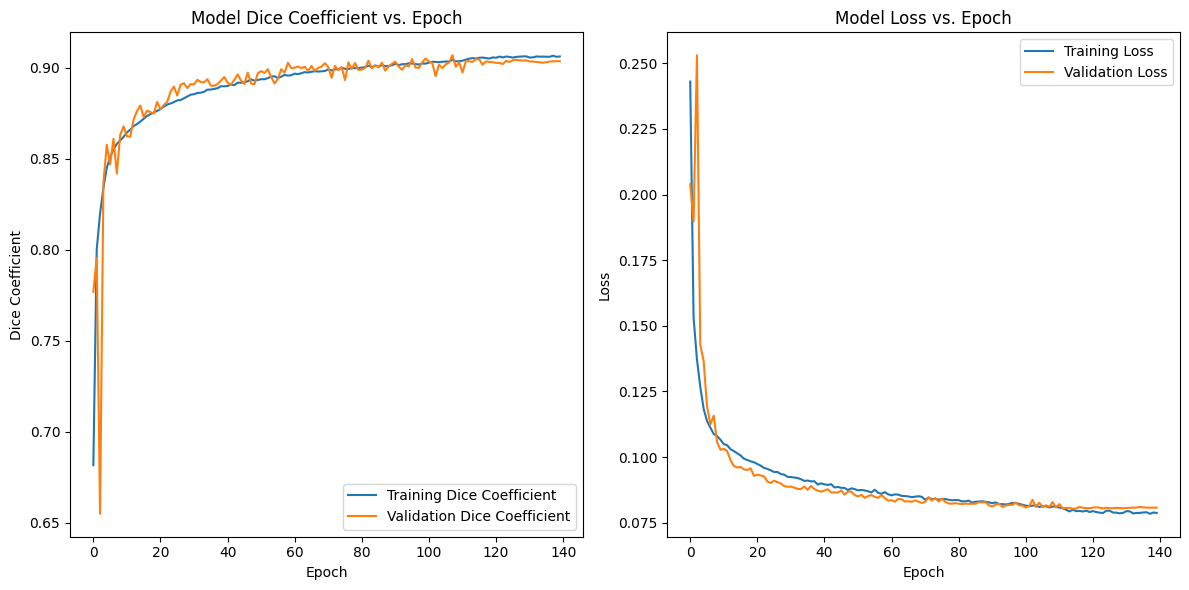

In [8]:
# --- 8. Plot Training History ---

print("\nPlotting training history...")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [9]:
# --- 9. Evaluate, Post-Process, and Visualize ---

print("\nPredicting on validation data...")
preds_val = model.predict(X_val)

def post_process_mask(mask):
    mask_8bit = (mask * 255).astype(np.uint8)
    binary_mask = cv2.adaptiveThreshold(mask_8bit, 255, 
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return closed_mask

print("Applying robust post-processing to close boundaries...")
preds_val_processed = np.array([post_process_mask(m) for m in preds_val])



Predicting on validation data...
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step
Applying robust post-processing to close boundaries...



--- Final Evaluation Metrics ---
True Positives (Boundary): 4426178
True Negatives (Not Boundary): 970586
False Positives (Incorrectly identified as Boundary): 349855
False Negatives (Missed Boundary): 544837


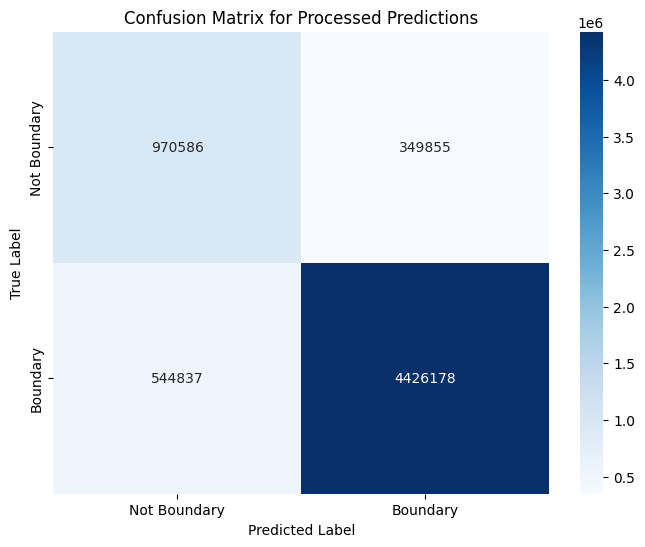

In [10]:
# --- 10. Confusion Matrix and Final Metrics ---

y_val_flat = (y_val > 0.5).astype(np.uint8).flatten()
preds_val_processed_flat = (preds_val_processed / 255).astype(np.uint8).flatten()

cm = confusion_matrix(y_val_flat, preds_val_processed_flat)
if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
else:
    tn, fp, fn, tp = 0, 0, 0, 0 
    print("Warning: Confusion matrix is not 2x2. Check predictions.")

print(f"\n--- Final Evaluation Metrics ---")
print(f"True Positives (Boundary): {tp}")
print(f"True Negatives (Not Boundary): {tn}")
print(f"False Positives (Incorrectly identified as Boundary): {fp}")
print(f"False Negatives (Missed Boundary): {fn}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Boundary', 'Boundary'], yticklabels=['Not Boundary', 'Boundary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Processed Predictions')
plt.show()


Displaying final visualization of results...


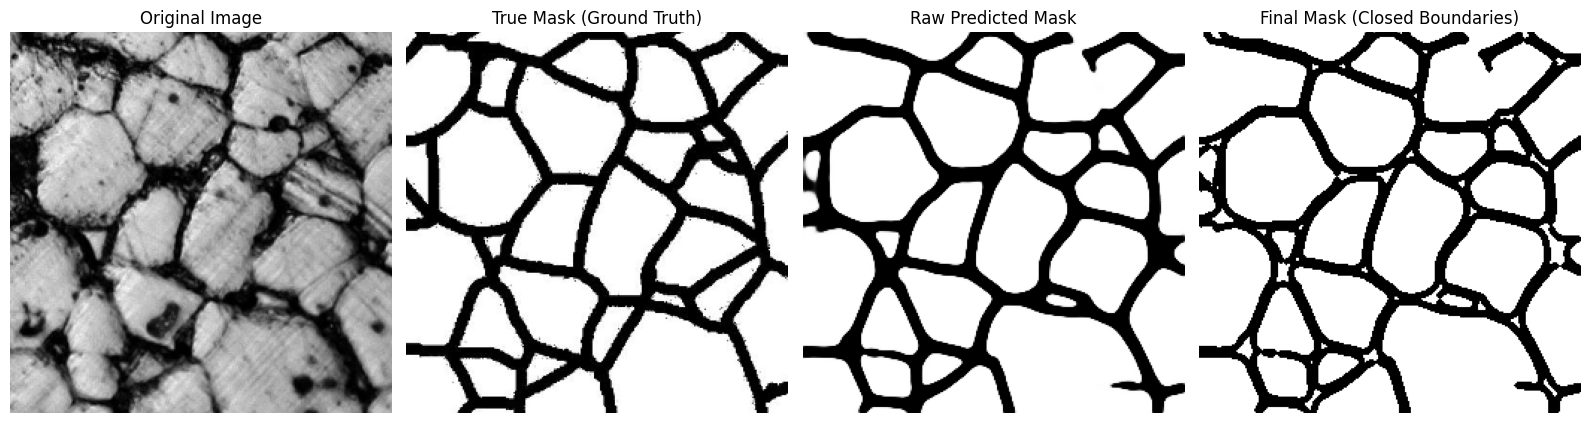

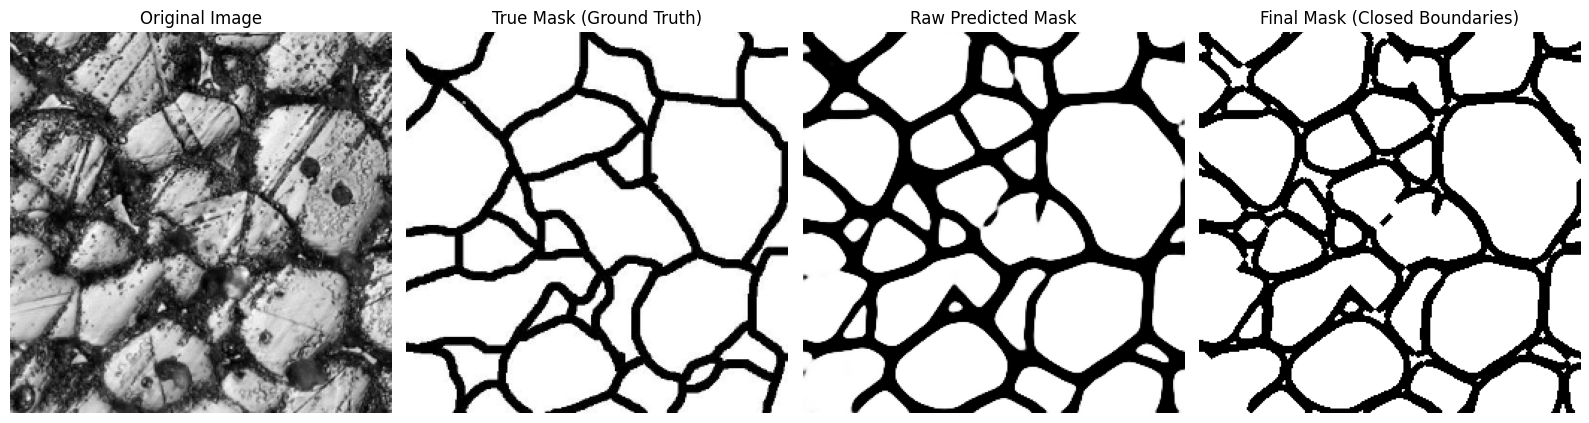

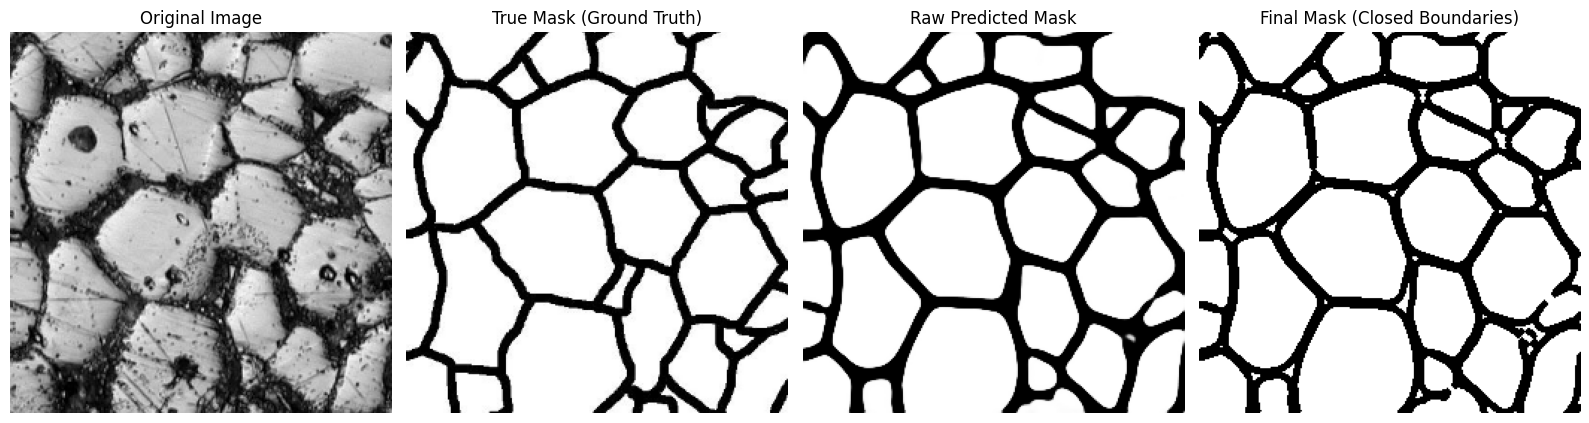

In [11]:
# --- 11. Final Visualization ---

print("Displaying final visualization of results...")
num_samples_to_show = 3
for i in np.random.choice(len(X_val), num_samples_to_show, replace=False):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.title("True Mask (Ground Truth)")
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title("Raw Predicted Mask")
    plt.imshow(preds_val[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title("Final Mask (Closed Boundaries)")
    plt.imshow(preds_val_processed[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
